In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

# Mutation rate, selection and genetic drift

We want to model the mutation rate dynamics in a population. The population has a constant size. All mutations are independent and their fitness effect is the same. Mutation rate can change through generations (increase or decrease with some probability)

In [76]:
class population():
    
    def __init__(self, nInd, mu=10e-4, s=0.01, plambda=0.1, fd=0.1): 
        #number of individuals
        self.nInd = nInd
        #selection coefficient
        self.s = s
        #initial mutation rate
        self.mu = mu
        #mutation rate of each individual equals mu
        self.mutation_rates = np.array([mu]*self.nInd)
        #parameter lambda determines the possible relative increase/decrease in mutation rate
        self.plambda = plambda
        #fd determines how likely it is to turn from mutator to antimutator
        self.fd = 0.1
        #genotype is described by the number of mutations
        self.genotypes = np.zeros(self.nInd) 
        #to think what we will save here (mutation frequencies? average fitness?)
        self.history = []
        #fitness of genotypes
        self.calculate_fitness()
        #mutators/antimutators (initially all individuals are equal)
        self.mutator_status = np.ones(self.nInd)
    
    def calculate_fitness(self):
        self.fitness = (1 - self.s)**self.genotypes

    def generation(self):
        #turning into mutator/non-mutator
        #probability to turn to antimutator for each individual
        p_antimutator = self.mutation_rates * 0.02 * self.fd
        #probability to turn to mutator for each individual
        p_mutator = self.mutation_rates * 0.02 * (1 - self.fd)
        #each individual can become mutator, antimutator or stay the same
        mutator_classes = []
        for i in range(self.nInd):
            mutator_class = np.random.choice([-1, 0, 1], 1, 
                                             p=[p_antimutator[i], 1-p_mutator[i]-p_antimutator[i], p_mutator[i]])
            mutator_classes.append(mutator_class[0])
        self.mutator_status += np.array(mutator_classes)
        self.mutation_rates = self.mutation_rates + np.array(mutator_classes)*self.mutation_rates*self.plambda
        #mutation (each individual mutates according to its out probability)
        mutations = []
        for i in range(self.nInd):
            #how many mutations happen in this individual
            mutation_n = np.random.poisson(self.mutation_rates[i], 1)
            mutations.append(mutation_n[0])
        self.genotypes += np.array(mutations)
        #fitness re-calculation
        self.calculate_fitness()
        #reproduction (we select nInd for new generation according to fitness values)
        new_indices = np.random.choice(np.arange(self.nInd), self.nInd, 
                                       replace=True, p=np.array(self.fitness)/np.sum(self.fitness))
        #fitness of new generation
        self.fitness = np.take(self.fitness, new_indices)
        #genotypes of new generation
        self.genotypes = np.take(self.genotypes, new_indices)
        #mutation rates of new generation
        self.mutation_rates = np.take(self.mutation_rates, new_indices)
        #mutator status of new generation
        self.mutator_status = np.take(self.mutator_status, new_indices)

    def evolve(self,nGen): 
        for i in range(nGen):
            #one generation = 1)turning into mutator/antimutator 2)mutation process 3)reproduction
            self.generation()
            #we can save some charateristics to check them later
            #self.history.append(len(self.genotypes[self.genotypes >= 1])/self.nInd)
            #self.history.append(np.unique(self.genotypes, return_counts=True))
            #self.history.append(self.fitness.mean())
            self.history.append(self.mutation_rates.mean())

    def plotTraj(self,ax="auto", color='blue'):
        if ax=="auto":
            plt.plot(self.history, label=f'N={self.nInd},s={self.s},mu_init={self.mu}', color=color)
            #plt.axis([0, len(self.history), 0, 1]) 
        #else:
            #plt.axis(ax)
            #ax.plot(self.traj)

In [126]:
#test run
nGen = 500
nInd = 1000
#We create a population and evolve it for nGen
pop = population(nInd, mu=1e-3, s=0.01)
pop.evolve(nGen)

No handles with labels found to put in legend.


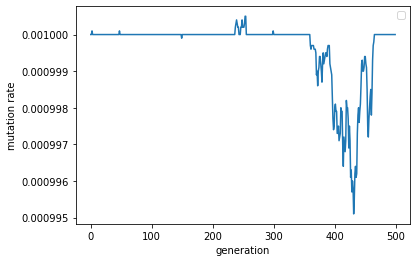

In [127]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(pop.history)
ax.set_xlabel('generation')
ax.set_ylabel('mutation rate')
plt.legend()

In [130]:
#how many mutators/antimutators are there after the evolution
np.unique(pop.mutator_status, return_counts=True)

(array([1.]), array([1000], dtype=int64))

Text(0, 0.5, 'counts')

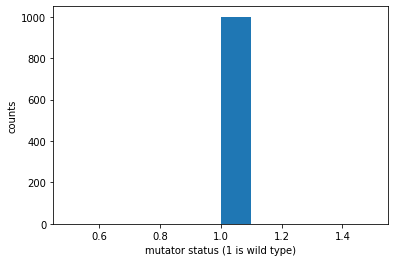

In [131]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(pop.mutator_status)
ax.set_xlabel('mutator status (1 is wild type)')
ax.set_ylabel('counts')

In [135]:
%%time
pop1 = population(nInd=100, s=0.01, mu=1e-5)
pop1.evolve(nGen=1000)
pop2 = population(nInd=100, s=0.01, mu=1e-4)
pop2.evolve(nGen=1000)
pop3 = population(nInd=100, s=0.01, mu=1e-3)
pop3.evolve(nGen=1000)

Wall time: 1min 10s


Text(0, 0.5, 'mutation rate')

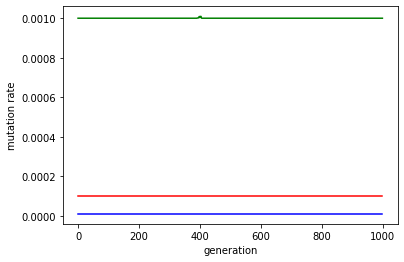

In [136]:
fig, ax = plt.subplots(figsize=(6, 4))

#old stuff - we used to plot the fration of individuals with more than 1 mutations
#pop1.plotTraj()
#pop2.plotTraj(color='red')
#pop3.plotTraj(color='green')
#ax.set_xlabel('generation')
#ax.set_ylabel('individuals with >= 1 mutations')
#plt.legend()

plt.plot(pop1.history, color='blue')
plt.plot(pop2.history, color='red')
plt.plot(pop3.history, color='green')
ax.set_xlabel('generation')
ax.set_ylabel('mutation rate')

In [ ]:
#add saving data in a file

# Mutation accumulation experiment

Mutation-accumulation (MA) experiment is used to experimentally measure the mutation rate. Fifty lines of an E. coli B strain were isolated by picking a single colony (the founder colony) from an agar plate, streaking onto a new plate, incubating overnight at 37 °C, then repeating the pick-streak-incubate procedure (called a growth cycle, GC) for 50 of the resultant colonies. These 50 lines were grown under identical conditions for 300 growth cycles. All fifty lines were derived from a single cell (the founding cell of the founder colony), and were genetically identical except for the mutations that might have occurred during colony expansion (growth
cycle 0). Throughout the mutation accumulation phase, there were ~25 rounds of cell division per growth cycle. Thus each line experienced 300 single cell bottlenecks and ~7,500 rounds of cell division. At growth cycles
0, 100, 120, 200, 250 and 300, sub-samples of each line were frozen in a glycerol-based suspension at -80 °C. These frozen samples were stored for use in fitness assays.

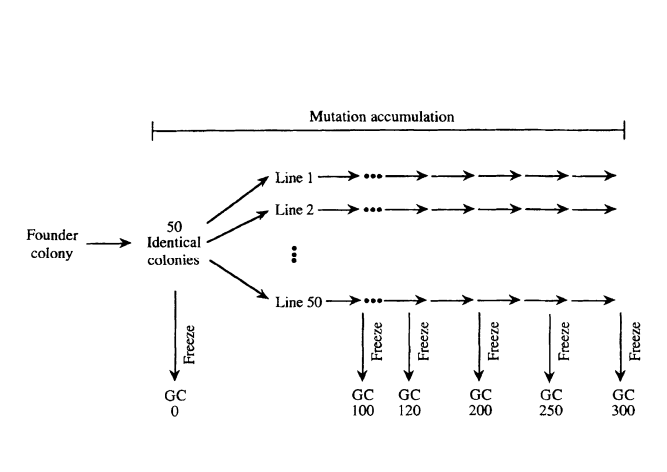

They estimate the mutation rate from the mathematical dependence between the relative fitness and time (circles on a plot below) and between among-line variance in fitness and time (squares on a plot below) 

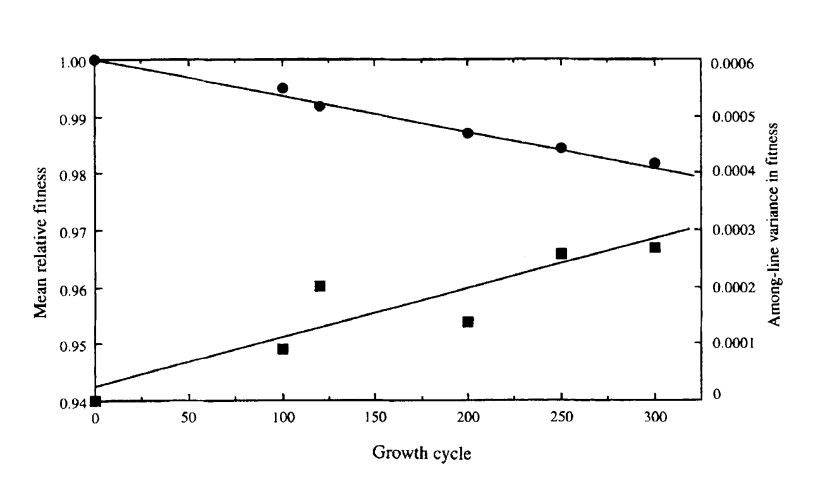

The following is a simulation of MA-experiment

In [45]:
class experiment():
    
    def __init__(self, mu=10e-4, s=0.01): 
        #selection coefficient
        self.s = s
        #mutation rate
        self.mu = mu
        #here we start from the population of a single individual
        #we describe each genotype simply by number of mutations relative to "wild-type" (wild-type=0)
        self.genotypes = np.zeros(1) 
        #later we want to track fitness through growth cycles
        self.gc_fitness = []
        #we calculate initial fitness of genotypes
        self.calculate_fitness()
    
    def calculate_fitness(self):
        #we assume here that all mutations are equally deleterious and independent
        #all mutations reduce fitness by s (i.e. fitness of a genotype with n mutations is (1-s)**n)
        self.fitness = (1 - self.s)**self.genotypes
        
        ##we can change this function to get more complicated calculation of fitness##

    def generation(self, exponential_growth=True):
        #mutation (at this stage each genotype can gain a mutation with probability mu)
        mutations = np.random.poisson(self.mu, len(self.genotypes))
        self.genotypes += mutations
        #we re-calculate fitness for mutants
        self.calculate_fitness()
        if exponential_growth:
            #every genotype is doubled, no matter how fit it is, the population size doubles
            self.genotypes = np.repeat(self.genotypes, 2)
        else:
            #genotypes reproduce according to their fitness, the population size remains constant
            self.genotypes = np.random.choice(self.genotypes, len(self.genotypes), 
                                              replace=True, p=np.array(self.fitness)/np.sum(self.fitness))
        np.random.shuffle(self.genotypes)

    def evolve(self, nGrowthCyc=300, nDivPerCyc=25):
        for gc in range(nGrowthCyc):
            #we pick up founder cell (one random individual from a population)
            if gc >= 1:
                self.genotypes = np.random.choice(self.genotypes, 1)
                self.calculate_fitness()
            #save fitness in a current cycle 
            self.gc_fitness.append(self.fitness)
            #growth phase (we put the selected cell on a plate and let it grow for nDivPerCyc generations)
            for i in range(nDivPerCyc):
                #we assume that first population grows exponentially and then it reaches stationary phase
                #15 is an arbitrary number, we can change it to any other reasonable value
                if i <= 15:
                    self.generation(exponential_growth=True)
                else:
                    self.generation(exponential_growth=False)

In [35]:
#How many times we will repeat the experiment (50 lines in the original paper)
nLines = 50
#Number of growth cycles (300 cycles in the original paper)
nGrowthCyc = 300
#Number of cell divisions per cycle (25 in the original paper)
nDivPerCyc = 10

In [25]:
experiment_results = []
#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment()
    exp.evolve(nGrowthCyc=300, nDivPerCyc=10)
    #we save fitness measurements for each line at each growth cycle
    experiment_results.append(exp.gc_fitness)
experiment_results = np.array(experiment_results)

In [46]:
#We have a matrix of shape (number of lines x number of growth cycles)
experiment_results.shape

(50, 300, 1)

Text(0, 0.5, 'Mean relative fitness')

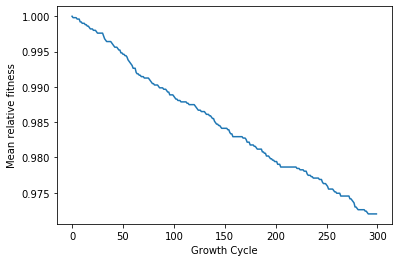

In [32]:
#Mean fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

Text(0, 0.5, 'Among-line variance in fitness')

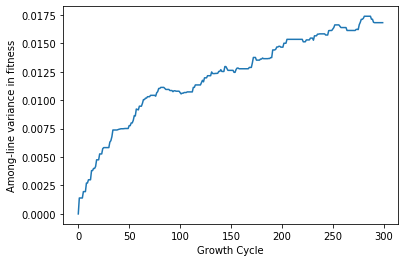

In [33]:
#Variance in fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [ ]:
#add mutation rate calculations

# References

1. The Lower Bound to the Evolution of Mutation Rates (https://doi.org/10.1093/gbe/evr066). Paper with population simulations described in details
2. Genetic drift, selection and the evolution of the mutation rate. https://www.nature.com/articles/nrg.2016.104. Main paper, the review about mutation rate evolution
3. https://github.com/SasankYadati/wright-fisher-population-genetics-simulation - github with Wright-Fisher simple model, this code is partially based on it.
4. Estimate of the genomic mutation rate deleterious to overall fitness in E. coli. https://www.nature.com/articles/381694a0. The paper with mutation accumulation experiment description.